# **Store On Google Drive**

In [ ]:
# Google Drive Mounting
#from google.colab import driveimport tensorflow as tf
import tensorflow as tf
import os
#drive.mount("/content/drive")
#datadir = 'drive/My Drive/Practical Deep Machine Learning/HW/flower_photos'
numberOfTestPerClass = 100 
pixels = 32
#!ls 'drive/My Drive/Practical Deep Machine Learning/HW/flower_photos'

_URL = "http://download.tensorflow.org/example_images/flower_photos.tgz"

zip_file = tf.keras.utils.get_file(origin=_URL,
                                   fname="flower_photos.tgz",
                                   extract=True)

datadir = os.path.join(os.path.dirname(zip_file), 'flower_photos')
print(datadir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
daisy  dandelion  roses  sunflowers  tulips


# **Store Locally**

In [ ]:
#datadir = '/home/ramyelgendi/Downloads/flower_photos'

# **Data Preprocessing**

In [ ]:
import os
def NavigateDirectory(Directory,numberOfTestPerClass):
  Folders = []
  ImageNamesTrain = []
  ImageNamesVal = []
  ImageNamesTest = []

  for file in os.listdir(Directory):    # Get Folders
    if(os.path.isdir(Directory+'/'+file)):
      Folders.append(file)

  for folder in Folders:                # Get Images
    temp=[]
    sortedtemp=[]
    for filename in os.listdir(Directory+'/'+folder):
      if filename.endswith("jpg"): temp.append(filename)
    
    sortedtemp = sorted(temp);
    ImageNamesTrain.append(sortedtemp[:-numberOfTestPerClass*2])
    ImageNamesVal.append(sortedtemp[-numberOfTestPerClass*2:-numberOfTestPerClass])
    ImageNamesTest.append(sortedtemp[-numberOfTestPerClass:])



  return Folders,ImageNamesTrain,ImageNamesVal,ImageNamesTest

In [ ]:
# Get Class names from Folders & image files (jpg)
Folders, ImageNamesTrain, ImageNamesVal, ImageNamesTest = NavigateDirectory(datadir,numberOfTestPerClass)
Folders = list(enumerate(Folders))
print(Folders)

[(0, 'roses'), (1, 'daisy'), (2, 'dandelion'), (3, 'sunflowers'), (4, 'tulips')]


In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

def Load(Directory,Folders, ImageNames):
  Images = []
  ImagesLabels = []
  
  for folder,listOfImages in zip(Folders,ImageNames):
    for name in listOfImages:
      image = cv2.imread(Directory+'/'+folder[1]+'/'+name)
      image = cv2.resize(image, (pixels,pixels),cv2.INTER_AREA) 
      Images.append(image)     
      ImagesLabels.append(folder[0]) # Number not name


  X = np.array(Images)
  Y = np.array(ImagesLabels)

  return X,Y

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt


# Images Loading
try:
   del TrainData, TrainLabels
   del TestData, TestLabels
   print('Clear previously loaded data.')
except:
   pass

TrainData,TrainLabels = Load(datadir,Folders,ImageNamesTrain)
ValData,ValLabels = Load(datadir,Folders,ImageNamesVal)
TestData,TestLabels = Load(datadir,Folders,ImageNamesTest)

TrainData = np.array(TrainData).astype(np.float32)
ValData = np.array(ValData).astype(np.float32)
TestData = np.array(TestData).astype(np.float32)

# Normalize the data: subtract the mean image
mean_image = np.mean(TrainData, axis=0)
TrainData -= mean_image
ValData -= mean_image
TestData -= mean_image

# Transpose so that channels come first
TrainData = TrainData.transpose(0, 3, 1, 2).copy()
ValData = ValData.transpose(0, 3, 1, 2).copy()
TestData = TestData.transpose(0, 3, 1, 2).copy()

print("Training data shape: ",TrainData.shape)
print("Training labels shape: ",TrainLabels.shape)
print("Val data shape: ",ValData.shape)
print("Val labels shape: ",ValLabels.shape)
print("Test data shape: ",TestData.shape)
print("Test labels shape: ",TestLabels.shape)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


ValueError: ignored

# **Gradient & Activation Functions**

In [ ]:
# GRADIENT FUNCTIONS --------------------------------------------------

def gradient_forwardprop(x, w, b):
    out = None
    X = x.reshape(x.shape[0], w.shape[0])
    z = np.einsum('ij,kj->ik', X, w.T,optimize=False)
    out = z+b
    cache = (x, w, b)

    return out, cache
    
def gradient_backwardprop(dout, cache):
    x, w, b = cache
    dx, dw, db = None, None, None
    dim_shape = np.prod(x[0].shape)
    N = x.shape[0]
    X = x.reshape(N, dim_shape)   # input gradient
    dx = np.einsum('ij,kj->ik', dout, w,optimize=False)
    dx = dx.reshape(x.shape)      # weight gradient
    dw = np.einsum('ij,kj->ik', X.T, dout.T,optimize=False )
    db = dout.sum(axis=0)

    return dx, dw, db

def softmax_loss(x, y):
    shifted_logits = x - np.max(x, axis=1, keepdims=True)
    Z = np.sum(np.exp(shifted_logits), axis=1, keepdims=True)
    log_probs = shifted_logits - np.log(Z)
    probs = np.exp(log_probs)
    N = x.shape[0]
    loss = -np.sum(log_probs[np.arange(N), y]) / N
    dx = probs.copy()
    dx[np.arange(N), y] -= 1
    dx /= N
    return loss, dx

def forward_relu_fullyconnected(x, w, b, gamma, beta):
    bn_cache, do_cache = None, None
    
    out, fc_cache = gradient_forwardprop(x,w,b)   # Forward Prop
    relu_cache = out
    out = np.maximum(0,out)
    return out, (fc_cache, bn_cache, relu_cache, do_cache)

def backward_relu_fullyconnected(dout, cache):
    fc_cache, bn_cache, relu_cache, do_cache = cache
    dout = dout * (cache > 0)
    dgamma, dbeta = None, None      # batch/layer norm
    dx, dw, db = gradient_backwardprop(dout, fc_cache)     # Backward Prop
    return dx, dw, db, dgamma, dbeta


def adam(w, dw, config=None):
    if config is None: config = {}
    config.setdefault('learning_rate', 1e-3)
    config.setdefault('beta1', 0.9)
    config.setdefault('beta2', 0.999)
    config.setdefault('epsilon', 1e-8)
    config.setdefault('m', np.zeros_like(w))
    config.setdefault('v', np.zeros_like(w))
    config.setdefault('t', 0)

    next_w = None
    eps, learning_rate = config['epsilon'], config['learning_rate']
    beta1, beta2 = config['beta1'], config['beta2']
    m, v, t = config['m'], config['v'], config['t']
    # Adam
    t = t + 1
    m = beta1 * m + (1 - beta1) * dw          # momentum
    mt = m / (1 - beta1**t)                   # bias correction
    v = beta2 * v + (1 - beta2) * (dw * dw)   # RMSprop
    vt = v / (1 - beta2**t)                   # bias correction
    next_w = w - learning_rate * mt / (np.sqrt(vt) + eps)
    # update values
    config['m'], config['v'], config['t'] = m, v, t

    return next_w, config

# **Fully Connected Neural Network**

In [ ]:
class FCNN(object):

    def __init__(self, data,hidden_dims, input_dim, num_classes, reg, weight_scale,num_epochs,batch_size,learning_rate):

        self.reg = reg
        self.num_layers = 1 + len(hidden_dims)
        self.params = {}
        
        layers_dims = np.hstack([input_dim, hidden_dims, num_classes])
        for i in range(self.num_layers):
            self.params['W'+str(i+1)] = weight_scale*np.random.randn(layers_dims[i],layers_dims[i+1])
            self.params['b'+str(i+1)] = np.zeros(layers_dims[i+1])

        # Cast all parameters to the correct datatype
        for k, v in self.params.items():
            self.params[k] = v.astype(np.float32)

        self.TrainData = data['TrainData']
        self.TrainLabels = data['TrainLabels']
        self.ValData = data['ValData']
        self.ValLabels = data['ValLabels']


        # Unpack keyword arguments
        self.optim_config = {"learning_rate":learning_rate} 
        self.batch_size = batch_size 
        self.num_epochs = num_epochs
        self.num_train_samples = len(data['TrainData'])
        self.num_val_samples = len(data['ValData'])

        # Declaration
        self.epoch = 0
        self.best_val_acc = 0
        self.best_params = {}
        self.train_loss_history = []
        self.val_loss_history = []
        self.loss_history = []
        self.train_acc_history = []
        self.val_acc_history = []

        # Make a deep copy of the optim_config for each parameter
        self.optim_configs = {}
        for p in self.params:
            d = {k: v for k, v in self.optim_config.items()}
            self.optim_configs[p] = d

    def loss(self, X, y=None):
        X = X.astype(np.float32)
        mode = 'test' if y is None else 'train'

        scores = None
        x = X
        caches = []
        gamma, beta = None, None
        for i in range(self.num_layers-1):
            w = self.params['W'+str(i+1)]
            b = self.params['b'+str(i+1)]
            x, cache = forward_relu_fullyconnected(x,w,b, gamma, beta )
            caches.append(cache)
        w = self.params['W'+str(self.num_layers)]
        b = self.params['b'+str(self.num_layers)]
        scores, cache = gradient_forwardprop(x,w,b)
        caches.append(cache)
        if mode == 'test':
            return scores

        loss, grads = 0.0, {}
        loss, softmax_grad = softmax_loss(scores, y)
        for i in range(self.num_layers):
            w = self.params['W'+str(i+1)]
            loss += 0.5 * self.reg * np.sum(w * w) 

        # calculate gradients
        dout = softmax_grad
        dout, dw, db = gradient_backwardprop(dout, caches[self.num_layers - 1])
        grads['W' + str(self.num_layers)] = dw + self.reg * self.params['W' + str(self.num_layers)]
        grads['b' + str(self.num_layers)] = db

        for i in range(self.num_layers - 2, -1, -1):
            dx, dw, db, dgamma, dbeta = backward_relu_fullyconnected(dout, caches[i])

            grads['W' + str(i + 1)] = dw + self.reg * self.params['W' + str(i + 1)]
            grads['b' + str(i + 1)] = db
            dout = dx
        return loss, grads

    def check_accuracy(self, X, y, num_samples=None, batch_size=100):
        # Maybe subsample the data
        N = X.shape[0]
        if num_samples is not None and N > num_samples:
            mask = np.random.choice(N, num_samples)
            N = num_samples
            X = X[mask]
            y = y[mask]

        # Compute predictions in batches
        num_batches = N // batch_size
        if N % batch_size != 0:
            num_batches += 1
        y_pred = []
        for i in range(num_batches):
            start = i * batch_size
            end = (i + 1) * batch_size
            scores = self.loss(X[start:end])
            y_pred.append(np.argmax(scores, axis=1))
        y_pred = np.hstack(y_pred)
        acc = np.mean(y_pred == y)

        return acc


    def train(self):
        """
        Run optimization to train the model.
        """
        num_train = self.TrainData.shape[0]
        iterations_per_epoch = max(num_train // self.batch_size, 1)
        num_iterations = self.num_epochs * iterations_per_epoch

        for t in range(num_iterations):
          # Make a minibatch of training data
          num_train = self.TrainData.shape[0]
          batch_mask = np.random.choice(num_train, self.batch_size)
          X_batch = self.TrainData[batch_mask]
          y_batch = self.TrainLabels[batch_mask]

          # Compute loss and gradient
          loss, grads = self.loss(X_batch, y_batch)
          self.loss_history.append(loss)

          # Perform a parameter update
          for p, w in self.params.items():
            dw = grads[p]
            next_w, next_config = adam(w, dw, self.optim_configs[p])
            self.params[p] = next_w
            self.optim_configs[p] = next_config

          # At the end of every epoch, increment the epoch counter and decay the learning rate.
          epoch_end = (t + 1) % iterations_per_epoch == 0
          if epoch_end:
              self.epoch += 1

          # Check train and val accuracy on the first iteration, the last iteration, and at the end of each epoch.
          first_it = (t == 0)
          last_it = (t == num_iterations - 1)
          if first_it or last_it or epoch_end:
              train_acc = self.check_accuracy(self.TrainData, self.TrainLabels,num_samples=self.num_train_samples)
              val_acc = self.check_accuracy(self.ValData, self.ValLabels,num_samples=self.num_val_samples)
              self.train_acc_history.append(train_acc)
              self.val_acc_history.append(val_acc)

              train_loss = self.loss(self.TrainData,self.TrainLabels)[0]
              val_loss = self.loss(self.ValData,self.ValLabels)[0]
              self.train_loss_history.append(train_loss)
              self.val_loss_history.append(val_loss)

              print('Epoch',self.epoch,'/',self.num_epochs,': Training Loss: ',train_loss,' Validation Loss: ',val_loss,' Training Accuracy: ',train_acc,' Validation Accuracy: ',val_acc)

              # Keep track of the best model
              if val_acc > self.best_val_acc:
                  self.best_val_acc = val_acc
                  self.best_params = {}
                  for k, v in self.params.items():
                      self.best_params[k] = v.copy()

        # At the end of training swap the best params into the model
        self.params = self.best_params

# **Main Function**

In [ ]:
np.random.seed(500)
data = {
  'TrainData':TrainData,
  'TrainLabels': TrainLabels,
  'ValData': ValData,
  'ValLabels': ValLabels,
}

# Obtained with random search
weight_scale =      2e-2 
learning_rate =     10**np.random.uniform(-3, -6)
reg =               10**np.random.uniform(-3, -4)
hidden_dims =       [100]*3
input_dim =         3*pixels*pixels
num_classes =       5
epochs =            87
batch_size=         100

model = FCNN(data,hidden_dims,input_dim,num_classes,reg,weight_scale,epochs,batch_size,learning_rate)
model.train()

Epoch 0 / 87 : Training Loss:  1.6900238066262847  Validation Loss:  1.706227888529521  Training Accuracy:  0.171  Validation Accuracy:  0.156
Epoch 1 / 87 : Training Loss:  1.6632967016528353  Validation Loss:  1.6867128740947535  Training Accuracy:  0.249  Validation Accuracy:  0.206
Epoch 2 / 87 : Training Loss:  1.6385252392954812  Validation Loss:  1.6684927356745192  Training Accuracy:  0.302  Validation Accuracy:  0.234
Epoch 3 / 87 : Training Loss:  1.616714340096014  Validation Loss:  1.6519343062272172  Training Accuracy:  0.303  Validation Accuracy:  0.264
Epoch 4 / 87 : Training Loss:  1.595508291121015  Validation Loss:  1.6367950795471033  Training Accuracy:  0.349  Validation Accuracy:  0.276
Epoch 5 / 87 : Training Loss:  1.5753575409057428  Validation Loss:  1.622575077974885  Training Accuracy:  0.342  Validation Accuracy:  0.288
Epoch 6 / 87 : Training Loss:  1.554765422298918  Validation Loss:  1.607769416329817  Training Accuracy:  0.368  Validation Accuracy:  0.29

In [ ]:
print("weight scale: ",weight_scale," learning rate: ",learning_rate," reg: ",reg)
print('Validation set accuracy: ', ( np.argmax(model.loss(TrainData), axis=1) ==TrainLabels).mean())
print('\n')
for i,name in enumerate(Folders):
  print('CCR',name[1].upper(),': ', (np.argmax(model.loss(TestData[numberOfTestPerClass*i:numberOfTestPerClass*i+numberOfTestPerClass]), axis=1) == TestLabels[numberOfTestPerClass*i:numberOfTestPerClass*i+numberOfTestPerClass]).mean())
print('ACCR: ', (np.argmax(model.loss(TestData), axis=1) == TestLabels).mean())



weight scale:  0.02  learning rate:  8.297770501072957e-06  reg:  0.0008675270144593566
Validation set accuracy:  0.802247191011236


CCR DAISY :  0.4
CCR DANDELION :  0.67
CCR SUNFLOWERS :  0.62
CCR TULIPS :  0.53
CCR ROSES :  0.39
ACCR:  0.522


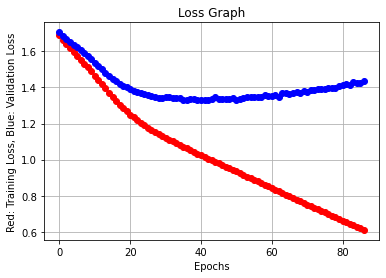

In [ ]:
plt.plot( range(epochs),model.train_loss_history[0:epochs], 'ro-',  range(epochs),model.val_loss_history[0:epochs], 'bo-')
plt.grid()
plt.title("Loss Graph")
plt.ylabel('Red: Training Loss, Blue: Validation Loss')
plt.xlabel('Epochs')
plt.show()

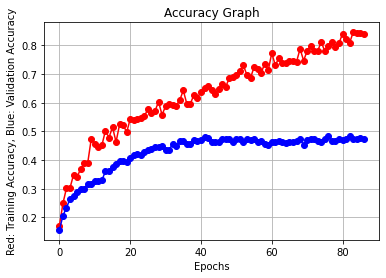

In [ ]:
plt.plot( range(epochs),model.train_acc_history[0:epochs], 'ro-',  range(epochs),model.val_acc_history[0:epochs], 'bo-')
plt.grid()
plt.title("Accuracy Graph")
plt.ylabel('Red: Training Accuracy, Blue: Validation Accuracy')
plt.xlabel('Epochs')
plt.show()